# Searcher Feature
## Query for Comments & Visualize Ratings Over Time

This feature allows users to type a query below and search for relevant comments in the dataset. The TripAdvisor rating per each guest is then used to plot a rating trend relative to the query over time.

Instructions:
1. Update `query_text` string to query you wish to search for in the TripAdivsor comments.
2. Make sure that you have the appropriate dataset name set in the `config.toml` file.

## Inputs & Setup

In [1]:
import metapy
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib import dates
%matplotlib inline
import seaborn as sns
import numpy as np


# Input variables
file_stem = "uo_wide"
query_text = "lockers"

## Query the data and create a dataframe for visualizing relevant queries

In [5]:
%%capture
# Create inverted index for searching
idx = metapy.index.make_inverted_index('config.toml')

RuntimeError: metadata input file ended prematurely

In [2]:
# Set up ranker & query
ranker = metapy.index.OkapiBM25() # Change this to change ranker
query = metapy.index.Document()
query.content(query_text) 

top_docs = ranker.score(idx, query, num_results=100)


# Create empty dataframe to hold relevant reviews
reviews_df = pd.DataFrame(columns = ['review_id', 'venue_name', 'review_date', 'content',
                                 'rating', 'helpful_vote', 'user_location', 'query_relevance'])

for num, (d_id, score) in enumerate(top_docs):
    
    if type(idx.metadata(d_id).get('review_id')):
        
        print(d_id)
        
        row = {
        'review_id' : str(idx.metadata(d_id).get('review_id')),
        'venue_name' : str(idx.metadata(d_id).get('venue_name')),
        'review_date' : str(idx.metadata(d_id).get('review_date')),
        'content' : str(idx.metadata(d_id).get('content')),
        'rating' : str(idx.metadata(d_id).get('rating')),
        'helpful_vote' : str(idx.metadata(d_id).get('helpful_vote')),
        'user_location' : str(idx.metadata(d_id).get('user_location')),
        'query_relevance' : score
        }

        reviews_df = reviews_df.append(row, ignore_index=True)

RuntimeError: metadata input file ended prematurely

In [3]:
# Convert & clean up data
reviews_df['rating'] = reviews_df['rating'].fillna(0)
reviews_df['rating']  = reviews_df['rating'].astype(int) / 10 # A 5 star rating is stored on TripAdvisor as 50
reviews_df['review_date'] = pd.to_datetime(reviews_df['review_date'], format='%B %d, %Y')
reviews_df['date_num'] = dates.datestr2num(reviews_df['review_date'].astype(str))
reviews_df['user_location'] = reviews_df['user_location'].str.strip('\r')
reviews_df = reviews_df.replace(r'\\n',' ', regex=True) 
reviews_df = reviews_df.replace(r'\\r',' ', regex=True) 

NameError: name 'reviews_df' is not defined

In [4]:
# Output to file
reviews_df.to_csv(file_stem + '_full_reviews.csv')
reviews_df[['review_id', 'venue_name', 'review_date', 'rating',
       'helpful_vote', 'user_location', 'query_relevance']].to_csv(file_stem + '_metadata_only.csv')

## Visualize Query-Relevant Ratings Trend Over Time

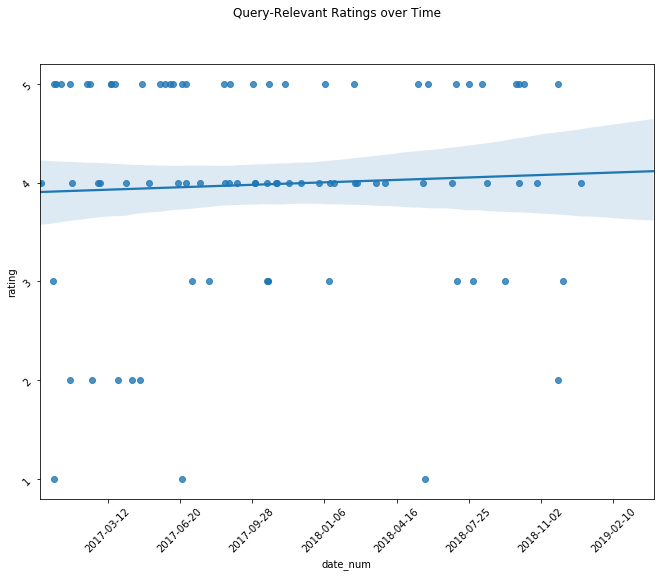

In [5]:
# Formatting the output for visualization of ratings over time
@plt.FuncFormatter
def formatted_dates(x, pos):
    return dates.num2date(x).strftime('%Y-%m-%d')

fig, ax = plt.subplots()
fig.suptitle('Query-Relevant Ratings over Time')
fig.set_size_inches(11, 8)

plt.yticks([1,2,3,4,5])
plt.ylabel('Review Rating')
plt.ylim(.8,5.2) # ratings can be between 1 and 5

plt.xlim(reviews_df['date_num'].min()+100, reviews_df['date_num'].max()+100) # changes based on date range of reviews
plt.xlabel('Review Date')

# just use regplot if you don't need a FacetGrid
sns.regplot('date_num', 'rating', data=reviews_df, ax=ax)

# here's the magic:
ax.xaxis.set_major_formatter(formatted_dates)

# legible labels
ax.tick_params(rotation=45)